**YOUR NAMES HERE**

Fall 2023

CS 343: Neural Networks

Project 2: Multi-layer Perceptrons

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# for obtaining the STL-dataset
import load_stl10_dataset

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.show()
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training mini-batch')
    plt.ylabel('Loss (cross-entropy)')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/nn/7dg3frxj7110d9z8g5flwtj80000gn/T/ipykernel_87574/1339317038.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
/var/folders/nn/7dg3frxj7110d9z8g5flwtj80000gn/T/ipykernel_87574/1339317038.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])


## Load in data

### a. STL-10

Run your function to load in the preprocessed STL-10 data in the following split:

- 3000 training samples
- 750 test samples
- 1000 validation samples
- 250 samples for development

In [14]:
stl_labels = np.load("numpy/labels.npy")
stl_imgs = np.load("numpy/images.npy")
stl_imgs_pp, stl_labels_pp = preprocess_data.preprocess_stl(stl_imgs, stl_labels)
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.create_splits(stl_imgs_pp, stl_labels_pp, 3000, 750, 1000, 250)

### b. Circle in a square

The circle in a square (CIS) dataset is a simple binary classification dataset that is useful for debugging and visualizing what your MLP is learning. Points with (x, y) coordinates inside a circle have class value of 1, points with coordinates outside the circle have class value of 0. Training on the CIS dataset allows us to answer the question: can the MLP learn to discriminate whether a test point falls inside or outside the circle?

#### Todo

- Download the CIS dataset then run the cell below to load in the CIS train (`cis_train.dat`) and test (`cis_test.dat`) sets as numpy arrays.
- Below, make a scatterplot showing the test set data. Color-code samples based on their class. If everything goes well, you should see a...solid, filled in circle inside unit square :)
    - Make the aspect ratio of your x, y plotting axes equal, otherwiwse you might see an ellipse!

In case you're curious about the data format:
- Like usual, each row is a different sample.
- The x-coordinate feature is the 1st column
- The y-coordinate feature is the 2nd column
- The class label (0 or 1) is in the third column.


In [11]:
val_size = 20

cis_train_path = os.path.join('data','cis_train.dat')
cis_test_path = os.path.join('data','cis_test.dat')

cis_train_all = np.loadtxt(cis_train_path, delimiter='\t')

# shuffle the data
s_inds = np.arange(len(cis_train_all))
np.random.seed(0)
np.random.shuffle(s_inds)

cis_train_all = cis_train_all[s_inds]

cis_train_x = cis_train_all[:, :2]
cis_train_y = cis_train_all[:, 2].astype(int)

cis_val_x = cis_train_x[:val_size]
cis_train_x = cis_train_x[val_size:]
cis_val_y = cis_train_y[:val_size]
cis_train_y = cis_train_y[val_size:]

cis_test_all = np.loadtxt(cis_test_path, delimiter='\t')
cis_test_x = cis_test_all[:, :2]
cis_test_y = cis_test_all[:, 2].astype(int)

print ('CIS Train data shape: ', cis_train_x.shape)
print ('CIS Train labels shape: ', cis_train_y.shape)
print ('CIS Validation data shape: ', cis_val_x.shape)
print ('CIS Validation labels shape: ', cis_val_y.shape)
print ('CIS Test data shape: ', cis_test_x.shape)
print ('CIS Test labels shape: ', cis_test_y.shape)

CIS Train data shape:  (80, 2)
CIS Train labels shape:  (80,)
CIS Validation data shape:  (20, 2)
CIS Validation labels shape:  (20,)
CIS Test data shape:  (10000, 2)
CIS Test labels shape:  (10000,)


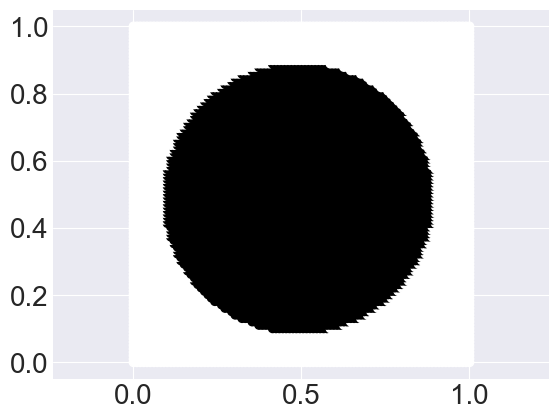

In [4]:
plt.scatter(cis_test_x[:,0], cis_test_x[:,1], c=cis_test_y)
plt.axis('equal')
plt.show()

## Task 3: Implement Multilayer Perceptron (MLP) with softmax activation and cross-entropy loss

Now that we've tested the softmax activation function and cross-entropy loss functions in a single-layer net, let's implement the MLP version.

Much of your work on the single layer net will carry over, so go ahead and copy-paste and modify as needed!

#### The structure of our MLP

```
Input layer (X units) ->
Hidden layer (Y units) with Rectified Linear activation (ReLu) ->
Output layer (Z units) with softmax activation
```

### 3a. Implement the following functions in `mlp.py`

- `initialize_wts`
- `accuracy`
- `one_hot`
- `predict`
- `forward`
- `backward`
- `fit`: see note below.

#### Updates to `fit`

Now that you have built and fit several neural networks, let's make a helpful update to the training process: in addition to recording the training loss and accuracy, record the accuracy on the **validation set** after every training epoch. Every `print_every` epochs print out validation accuracy to monitor performance on the validation set. See the `fit` docstring for details.

### 3b. Test key functions with randomly generated data

In [15]:
from mlp import MLP

In [16]:
# Create a dummy net for debugging
num_inputs = 3
num_features = 6
num_hidden_units = 7
num_classes = 5

net = MLP(num_features, num_hidden_units, num_classes)

In [17]:
# Generate random data and classes
np.random.seed(0)
test_x = np.random.normal(loc=0, scale=100, size=(num_inputs, num_features))
test_y = np.random.uniform(low=0, high=num_classes-1, size=(num_inputs,))
test_y = test_y.astype(int)
print(f'Test input shape: {test_x.shape}')
print(f'Test class vector shape: {test_y.shape}')

Test input shape: (3, 6)
Test class vector shape: (3,)


#### Test `initialize_wts`

In [6]:
net.initialize_wts(M=num_features, H=num_hidden_units, C=num_classes, std=0.01)
print(f'y wt shape is {net.y_wts.shape} and should be (6, 7)')
print(f'y bias shape is {net.y_b.shape} and should be (7,)')
print(f'z wt shape is {net.z_wts.shape} and should be (7, 5)')
print(f'z bias shape is {net.z_b.shape} and should be (5,)')

print(f'1st few y wts are\n{net.y_wts[:,0]}\nand should be\n[ 0.018 -0.002  0.004  0.007  0.015  0.002]')
print(f'y bias is\n{net.y_b}\nand should be\n[ 0.016 -0.006 -0.005 -0.011  0.009 -0.023  0.017]')
print(f'1st few z wts are\n{net.z_wts[:,0]}\nand should be\n[-0.004 -0.008  0.006 -0.006 -0.009 -0.002 -0.003]')
print(f'z bias is\n{net.z_b}\nand should be\n[ 0.018  0.004  0.001 -0.019 -0.003]')

y wt shape is (6, 7) and should be (6, 7)
y bias shape is (7,) and should be (7,)
z wt shape is (7, 5) and should be (7, 5)
z bias shape is (5,) and should be (5,)
1st few y wts are
[ 0.018 -0.002  0.004  0.007  0.015  0.002]
and should be
[ 0.018 -0.002  0.004  0.007  0.015  0.002]
y bias is
[ 0.016 -0.006 -0.005 -0.011  0.009 -0.023  0.017]
and should be
[ 0.016 -0.006 -0.005 -0.011  0.009 -0.023  0.017]
1st few z wts are
[-0.004 -0.008  0.006 -0.006 -0.009 -0.002 -0.003]
and should be
[-0.004 -0.008  0.006 -0.006 -0.009 -0.002 -0.003]
z bias is
[ 0.018  0.004  0.001 -0.019 -0.003]
and should be
[ 0.018  0.004  0.001 -0.019 -0.003]


#### Test the `predict` method

In [10]:
test_y_pred = net.predict(test_x)
print(f'Predicted classes are {test_y_pred} and should be [1 1 1]')

Predicted classes are [1 1 1] and should be [1 1 1]


#### Test the `forward` method focusing on`ReLU`(net act of hidden layer `y`)

In [11]:
_,y_net_act_test,_,_,_ = net.forward(test_x, test_y)

correct_y_act = np.array([[7.676, 4.464, 0.799, 9.97 , 0.   , 0.   , 0.   ],
       [2.386, 2.711, 2.174, 2.541, 0.366, 0.   , 0.   ],
       [4.013, 2.665, 1.19 , 3.023, 0.   , 0.   , 0.   ]])

print(f'Your y activation is\n{y_net_act_test}')
print(f'The correct y activation (ReLU) is\n{correct_y_act}')

Your y activation is
[[7.676 4.464 0.799 9.97  0.    0.    0.   ]
 [2.386 2.711 2.174 2.541 0.366 0.    0.   ]
 [4.013 2.665 1.19  3.023 0.    0.    0.   ]]
The correct y activation (ReLU) is
[[7.676 4.464 0.799 9.97  0.    0.    0.   ]
 [2.386 2.711 2.174 2.541 0.366 0.    0.   ]
 [4.013 2.665 1.19  3.023 0.    0.    0.   ]]


#### Test the `forward` method

In [12]:
_,_,_,probs,_ = net.forward(test_x, test_y)

correct_probs = np.array([[0.193, 0.223, 0.194, 0.21 , 0.18 ],
       [0.2  , 0.219, 0.194, 0.194, 0.193],
       [0.2  , 0.216, 0.191, 0.204, 0.189]])

print(f'Your z activation (class probabilities) is\n{probs}')
print(f'The correct z activation (class probabilities) is\n{correct_probs}')
print(f'The sums for each row (data sample) are {np.sum(probs, axis=1)}.')
print(f'  You should know what should be :)')

Your z activation (class probabilities) is
[[0.193 0.223 0.194 0.21  0.18 ]
 [0.2   0.219 0.194 0.194 0.193]
 [0.2   0.216 0.191 0.204 0.189]]
The correct z activation (class probabilities) is
[[0.193 0.223 0.194 0.21  0.18 ]
 [0.2   0.219 0.194 0.194 0.193]
 [0.2   0.216 0.191 0.204 0.189]]
The sums for each row (data sample) are [1. 1. 1.].
  You should know what should be :)


#### Test the `forward` method, focusing on loss

In [13]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y)
correct_loss = 1.6301413611153333

print(f'Your average loss is\n{loss}')
print(f'The correct average loss is approx\n{correct_loss}')

Your average loss is
1.6301413611153333
The correct average loss is approx
1.6301413611153333


#### Test the `forward` method, focusing on regularization

In [13]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y, reg=1000)
correct_loss = 6.321940739049808

print(f'Your regularized average loss is\n{loss}')
print(f'The correct regularized average loss is approx\n{correct_loss}')

Your regularized average loss is
6.321940739049807
The correct regularized average loss is approx
6.321940739049808


#### Test the `backward` method

In [7]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y, reg=0.5)
grads = net.backward(test_x, test_y, y_in, y_act ,z_in, z_act, reg=0.5)

print('Your gradient for y_wts is\n', grads[0])
print('Your gradient for y_b is\n', grads[1])
print('Your gradient for z_wts is\n', grads[2])
print('Your gradient for z_b is\n', grads[3])

Your gradient for y_wts is
 [[ 0.45   0.317  0.099  0.089 -0.204 -0.005  0.005]
 [-0.094 -0.001 -0.032  0.157  0.041  0.004  0.001]
 [-0.089  0.059 -0.038  0.301  0.025 -0.004 -0.013]
 [ 0.16   0.222  0.006  0.317 -0.099  0.    -0.001]
 [-0.005  0.215 -0.048  0.558 -0.037 -0.01  -0.002]
 [ 0.804  0.215  0.256 -0.807 -0.328 -0.005 -0.007]]
Your gradient for y_b is
 [ 0.005  0.003  0.001 -0.    -0.002  0.     0.   ]
Your gradient for z_wts is
 [[-2.977  1.034  0.1    0.971  0.858]
 [-1.734  0.724 -0.276  0.663  0.606]
 [-0.384  0.315 -0.456  0.271  0.265]
 [-3.321  1.145  0.161  1.063  0.952]
 [ 0.02   0.026 -0.097  0.019  0.022]
 [-0.001 -0.003 -0.006 -0.007 -0.001]
 [-0.001  0.011 -0.012  0.001  0.002]]
Your gradient for z_b is
 [-0.469  0.219 -0.14   0.202  0.187]


The correct gradients are:

```
Your gradient for y_wts is
 [[ 0.45   0.317  0.099  0.089 -0.204 -0.005  0.005]
 [-0.094 -0.001 -0.032  0.157  0.041  0.004  0.001]
 [-0.089  0.059 -0.038  0.301  0.025 -0.004 -0.013]
 [ 0.16   0.222  0.006  0.317 -0.099  0.    -0.001]
 [-0.005  0.215 -0.048  0.558 -0.037 -0.01  -0.002]
 [ 0.804  0.215  0.256 -0.807 -0.328 -0.005 -0.007]]
Your gradient for y_b is
 [ 0.005  0.003  0.001 -0.    -0.002  0.     0.   ]
Your gradient for z_wts is
 [[-2.977  1.034  0.1    0.971  0.858]
 [-1.734  0.724 -0.276  0.663  0.606]
 [-0.384  0.315 -0.456  0.271  0.265]
 [-3.321  1.145  0.161  1.063  0.952]
 [ 0.02   0.026 -0.097  0.019  0.022]
 [-0.001 -0.003 -0.006 -0.007 -0.001]
 [-0.001  0.011 -0.012  0.001  0.002]]
Your gradient for z_b is
 [-0.469  0.219 -0.14   0.202  0.187]
```

#### Test loss over epoch (1 of 2). 

The below code should generate a curve that rapidly drops to 0 (there might be fluctuations and it might not be monotonic and that's ok)

Your `fit` function should show you print-outs showing:
- Loss and validation accuracy 4 times throughout training.
- 100% accuracy on validation set after around 5 epochs of training.
- You are training on 20 epochs.
- There are 20 iterations.
- There is 1 iteration per epoch.

Here is an example print-out from `fit`:

    Starting to train network...There will be 20 epochs and 20 iterations total, 1 iter/epoch.
    Completed Epoch 0/19. Training loss: 13.44. Training acc:  33.33%. Validation acc:  33.33%.
    Completed Epoch 5/19. Training loss: 0.62. Training acc: 100.00%. Validation acc: 100.00%.
    Completed Epoch 10/19. Training loss: 0.16. Training acc: 100.00%. Validation acc: 100.00%.
    Completed Epoch 15/19. Training loss: 0.07. Training acc: 100.00%. Validation acc: 100.00%.
    Finished training!


epoch: 0 ------ loss: 13.440136359626294 
------ train acc:0.3333333333333333 ------ val acc: 0.3333333333333333

epoch: 5 ------ loss: 0.6164361358683074 
------ train acc:1.0 ------ val acc: 1.0

epoch: 10 ------ loss: 0.15680210939754913 
------ train acc:1.0 ------ val acc: 1.0

epoch: 15 ------ loss: 0.06630570829962805 
------ train acc:1.0 ------ val acc: 1.0


Lengths of each output list:
len(loss_hist)=20, len(acc_train)=20, len(acc_valid)=20
Each should be 20.


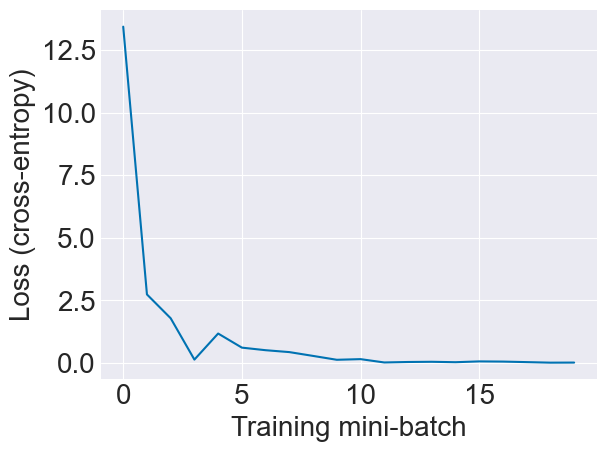

In [19]:
net = MLP(num_features, num_hidden_units, num_classes)
loss_hist, acc_train, acc_valid = net.fit(test_x, test_y, test_x, test_y, reg=0, print_every=5, lr=0.001, mini_batch_sz=3, n_epochs=20)

print('\nLengths of each output list:')
print(f'{len(loss_hist)=}, {len(acc_train)=}, {len(acc_valid)=}')
print('Each should be 20.')

plot_cross_entropy_loss(loss_hist)

#### Test loss over epoch (2 of 2). 

The below curve should look similar.

Your `fit` function should print out:
- Loss and validation accuracy 5 times throughout training.
- 100% accuracy on validation set after around 4 epochs of training.
- You are training on 10 epochs.
- There are 30 iterations.
- There are 3 iterations per epoch.


epoch: 0 ------ loss: 1.0396205097393195e-06 
------ train acc:0.6666666666666666 ------ val acc: 0.6666666666666666

epoch: 2 ------ loss: 2.865512832085888 
------ train acc:0.6666666666666666 ------ val acc: 0.6666666666666666

epoch: 4 ------ loss: 1.114693671751997 
------ train acc:1.0 ------ val acc: 1.0

epoch: 6 ------ loss: 0.03064675310837126 
------ train acc:1.0 ------ val acc: 1.0

epoch: 8 ------ loss: 0.004667817100768568 
------ train acc:1.0 ------ val acc: 1.0


Lengths of each output list:
len(loss_hist)=30, len(acc_train)=10, len(acc_valid)=10
The lengths should be 30, 10, 10.


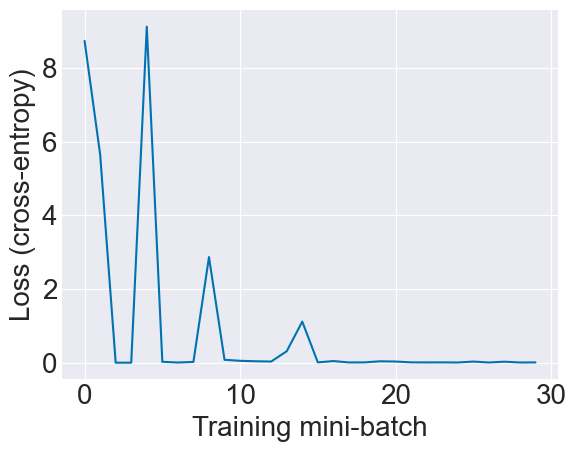

In [20]:
net = MLP(num_features, num_hidden_units, num_classes)
loss_hist, acc_train, acc_valid = net.fit(test_x, test_y, test_x, test_y, reg=0, print_every=2, lr=0.001, mini_batch_sz=1, n_epochs=10)

print('\nLengths of each output list:')
print(f'{len(loss_hist)=}, {len(acc_train)=}, {len(acc_valid)=}')
print('The lengths should be 30, 10, 10.')

plot_cross_entropy_loss(loss_hist)


### 3c. Test MLP with Circle in Square dataset

Before you run your MLP on the STL-10 dataset, test it out on the simpler CIS dataset.

In cells below:
- Train an MLP using the CIS training and validation sets. Configure the MLP with the following non-default hyperparameters:
    - 50 hidden units
    - Learning rate of 0.5
    - Mini-batch size of 80
    - 600 epochs
- Plot the loss over training iterations. You should see:
    - A nice drop and plateau in mini-batch training loss (*with a few potentially large fluctuations along the way*).
    - Accuracy on the validation set reach ~95%.
- Create a scatter plot of the MLP predictions on the CIS test set. Color-code each sample by its class. Make sure your axis aspect ratios are equal.

epoch: 0 ------ loss: 0.6938584042684729 
------ train acc:0.425 ------ val acc: 0.55

epoch: 100 ------ loss: 0.6801908954368522 
------ train acc:0.675 ------ val acc: 0.65

epoch: 200 ------ loss: 0.5781999587293314 
------ train acc:0.875 ------ val acc: 0.75

epoch: 300 ------ loss: 0.3441188049957169 
------ train acc:0.85 ------ val acc: 0.85

epoch: 400 ------ loss: 0.27264354661203916 
------ train acc:0.825 ------ val acc: 0.8

epoch: 500 ------ loss: 0.15083722947154335 
------ train acc:0.975 ------ val acc: 0.95



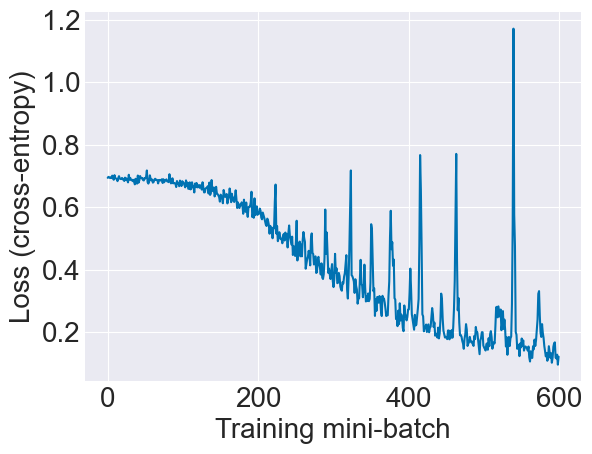

In [22]:
net_cis = MLP(2, 50, 2)
loss, trian, val =net_cis.fit(cis_train_x, cis_train_y, cis_val_x, cis_val_y, False, 600, 0.5, 80,0)
plot_cross_entropy_loss(loss)

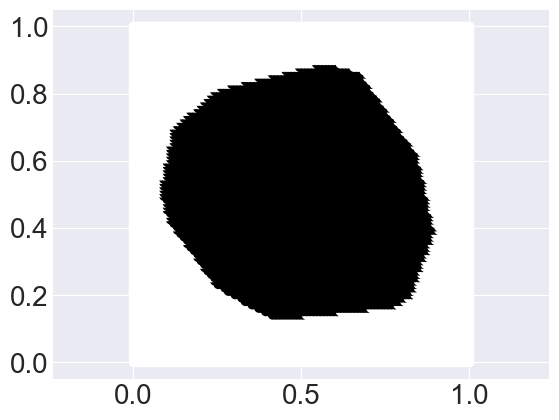

In [23]:
c_pred_y = net_cis.predict(cis_test_x)
plt.scatter(cis_test_x[:,0], cis_test_x[:,1], c=c_pred_y)
plt.axis('equal')
plt.show()

**Question 5**: How do you interpret the circle-in-square scatterplot? Is the MLP doing a good job? 

**Question 6**: Play with
- number of hidden units
- number of epochs
- batch size

How does each parameter affect the results?

**Question 7**: Do you think the single-layer net (with softmax) can handle the CIS dataset? Why or why not? (You're invited to try it, maybe as an extension :)

**Answer 5**:

**Answer 6**:

**Answer 7**: No, I believe that the single layer would struggle since it is only able 

### 3d. Test on STL-10 dataset, plot performance

Train an MLP on the STL-10 training set with the following non-default hyperparameters:
- 50 hidden units
- Learning rate of 0.1
- Regularization strength of 0.001
- Mini-batch size of 500
- 100 epochs
    
Make two plots:
- Plot the training loss (like usual). *Remember: the units are mini-batches.*
- Plot the training and validation set accuracies (2 curves in one plot — include a legend, title, axis labels, etc.). *Remember: the units are epochs.*

**Question 8**: What do the above loss and training and validation accuracy curves suggest about the quality of the hyperparameters used during training?

**Answer 8:**

### 3e. Optimize on STL-10 dataset with random search

To optimize your MLP hyperparameters on STL-10, try a **random search** rather than a grid search. This means that instead of defining preset *values* that each hyperparameter takes on, define *ranges* (min and max values).

Run your search for some $T$ iterations. On each iteration, randomly assign values to each hyperparameter within their valid ranges.

Just like grid search, print out the accuracy and parameter values every time a bout of training yields the **best accuracy** on the **STL-10 validation set**. That way, if you need to stop the search prematurely, you know the current best parameter combination.

Consider combinations of the following hyperparameters:
- learning rate
- regularization strength
- number of hidden units
- mini-batch size
- number of epochs (try between `1` and `150`). *Reduce the upper limit if your machine is taking too long to train a net with this many epochs.*

**Important note:** Like usual, I am not grading based on your performance numbers. I want to see that you successfully implemented the random search to find progressively better hyperparameters on STL-10.

**Tips:**
- Just like with grid search, if you find a cluster of parameters that seems promising, you can revise your search to hone in on that smaller range.
- Turn off print outs from `fit` (adjust `verbose` argument) and only print out things related to your search.
- If you are getting `RuntimeWarning`, your learning rate may be too high.

### 3f. Plot STL-10 results with best hyperparameters

Train an MLP with the best hyperparameters that you found from your parameter search and create two plots:
- Training STL-10 loss curve
- Training and validation set STL-10 accuracy curves

**Question 9**: Use your best trained network to compute the accuracy on the test set. What accuracy do you get?

**Question 10:** Why would you use random search over grid search when optimizing parameters on a dataset?

**Answer 9**:

**Answer 10:**

### 3g. Visualize learned weights

Run the `plot_weights` function to generate a grid visualization of them.

You should see structure in the weights if your network is performing well. If you have a large number of hidden units, some may not be "used" so a subset of the weights may resemble "noise".

In [ ]:
best_y_wts = bestNet.get_y_wts()
best_y_wts = best_y_wts.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)

In [ ]:
def plot_weights(wts, maxRows=25, verbose=0):
    # limit height of figure by number of neurons
    grid_sz = int(maxRows)
    grid_sz = np.minimum(grid_sz, int(np.sqrt(len(wts))))

    if verbose > 0:
        print(f'Showing {grid_sz} rows')
    
    plt.figure(figsize=(20,20))
    for x in range(grid_sz):
        for y in range(grid_sz):
            lin_ind = np.ravel_multi_index((x, y), dims=(grid_sz, grid_sz))
            plt.subplot(grid_sz, grid_sz, lin_ind+1)
            currImg = wts[lin_ind]
            low, high = np.min(currImg), np.max(currImg)
            currImg = 255*(currImg - low) / (high - low)
            currImg = currImg.astype('uint8')
            plt.imshow(currImg)
            plt.gca().axis('off')
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

In [ ]:
plot_weights(best_y_wts, verbose=1)

## Task 4: Hidden layer activation functions

In this task, you will explore the effects of using different activation functions in the **hidden** layer on training. Specifically, you compare ReLU (that you already have implemented) with:
- Sigmoid
- Exponential linear unit (ELU)

In [18]:
from mlp import MLP2

### 4a. Implement `MLP2` class and add support for several new hidden layer activation functions

Implement the following methods in `MLP2` at the bottom of `mlp.py`:
- constructor: one line to be added.
- `forward`: Copy-and-paste from `MLP` `forward` method and modify your code to support either ReLU, sigmoid, or Leaky ReLU hidden layer activation functions.
- `backward`: Copy-and-paste from `MLP` `forward` method and modify your code to support either ReLU, sigmoid, or Leaky ReLU hidden layer activation functions.

**Note:**
- A network should only use ONE of the hidden activation function options. Once it is set in the `MLP2` constructor, it is assumed to remain fixed forever.
- You should only add support for different **hidden layer activation functions** — not output layer activation functions (keep that as softmax).

#### Summary of hidden activation functions to implement

##### 1. ReLU
You already have this implemented.

##### 2. Sigmoid

Activation function:
$$f(netIn_i) = 1 / \left (1 + e^{-netIn_i} \right )$$

Gradient:
$$\frac{\partial f}{\partial netIn_i} = f(netIn_i) \left (1 - f(netIn_i) \right )$$

##### 3. Exponential linear unit (ELU)

Activation function:
$$f(netIn_i) = \begin{cases}
  netIn_i  & netIn_i \geq 0 \\
  e^{netIn_i} - 1 & netIn_i < 0
\end{cases}$$

Gradient:
$$\frac{\partial f}{\partial netIn_i} = \begin{cases}
  1  & netIn_i \geq 0 \\
  e^{netIn_i} & netIn_i < 0
\end{cases}$$

#### Test setup

In [16]:
# Create a dummy values for debugging
num_inputs = 4
num_features = 5
num_hidden_units = 6
num_classes = 3

# Generate random data and classes
np.random.seed(0)
dev_x = np.random.normal(loc=0, scale=1, size=(num_inputs, num_features))
dev_y = np.random.uniform(low=0, high=num_classes-1, size=(num_inputs,))
dev_y = dev_y.astype(int)
print(f'Dev input shape: {dev_x.shape}')
print(f'Dev class vector shape: {dev_y.shape}')

Dev input shape: (4, 5)
Dev class vector shape: (4,)


#### Test (1/3): Sigmoid

In [19]:
# sigmoid
sig_net = MLP2(num_features, num_hidden_units, num_classes, hidden_act_fun='sigmoid')

##### Forward

In [20]:
y_in, y_act ,z_in, z_act, loss = sig_net.forward(dev_x, dev_y)
correct_loss = 1.102608030800576

print(f'Your average loss (sigmoid hidden) is\n{loss}')
print(f'The correct average loss is approx\n{correct_loss}')
print(f'The first sample hidden act values are:\n{y_act[0]}\nand should be\n[0.747 0.39  0.4   0.61  0.74  0.436]')

Your average loss (sigmoid hidden) is
1.102608030800576
The correct average loss is approx
1.102608030800576
The first sample hidden act values are:
[0.747 0.39  0.4   0.61  0.74  0.436]
and should be
[0.747 0.39  0.4   0.61  0.74  0.436]


##### Backward

In [21]:
y_in, y_act ,z_in, z_act, loss = sig_net.forward(dev_x, dev_y)
grads = sig_net.backward(dev_x, dev_y, y_in, y_act ,z_in, z_act)

print(f'Your gradient for y_wts (sigmoid hidden) is\n{grads[0]}\nand should be:')
correct_grad = '''[[-0.001 -0.031 -0.017  0.019 -0.007  0.009]
 [-0.017  0.004 -0.001  0.017  0.013  0.011]
 [-0.004 -0.002 -0.002  0.007  0.003  0.004]
 [-0.006 -0.027 -0.016  0.023 -0.002  0.012]
 [-0.006 -0.002 -0.002  0.009  0.005  0.006]]'''
print(correct_grad)

Your gradient for y_wts (sigmoid hidden) is
[[-0.001 -0.031 -0.017  0.019 -0.007  0.009]
 [-0.017  0.004 -0.001  0.017  0.013  0.011]
 [-0.004 -0.002 -0.002  0.007  0.003  0.004]
 [-0.006 -0.027 -0.016  0.023 -0.002  0.012]
 [-0.006 -0.002 -0.002  0.009  0.005  0.006]]
and should be:
[[-0.001 -0.031 -0.017  0.019 -0.007  0.009]
 [-0.017  0.004 -0.001  0.017  0.013  0.011]
 [-0.004 -0.002 -0.002  0.007  0.003  0.004]
 [-0.006 -0.027 -0.016  0.023 -0.002  0.012]
 [-0.006 -0.002 -0.002  0.009  0.005  0.006]]


#### Test (2/3): ELU

In [22]:
# elu
leaky_net = MLP2(num_features, num_hidden_units, num_classes, hidden_act_fun='elu')

##### Forward

In [23]:
y_in, y_act ,z_in, z_act, loss = leaky_net.forward(dev_x, dev_y)
correct_loss = 1.0681289067131272

print(f'Your average loss (elu hidden) is:\n{loss}')
print(f'The correct average loss is approx\n{correct_loss}')
print(f'The first sample hidden act values are:\n{y_act[0]}\nand should be\n[ 1.08  -0.361 -0.333  0.449  1.048 -0.226]')

Your average loss (elu hidden) is:
1.0681289067131272
The correct average loss is approx
1.0681289067131272
The first sample hidden act values are:
[ 1.08  -0.361 -0.333  0.449  1.048 -0.226]
and should be
[ 1.08  -0.361 -0.333  0.449  1.048 -0.226]


##### Backward

In [33]:
y_in, y_act ,z_in, z_act, loss = leaky_net.forward(dev_x, dev_y)
grads = leaky_net.backward(dev_x, dev_y, y_in, y_act ,z_in, z_act)

print(f'Your gradient for y_wts (elu hidden) is\n{grads[0]}\nand should be:')
correct_grad = '''[[-0.007 -0.098 -0.052  0.08  -0.03   0.028]
 [-0.065 -0.003 -0.003  0.069  0.043  0.037]
 [-0.02  -0.001 -0.003  0.03   0.01   0.014]
 [-0.027 -0.085 -0.048  0.097 -0.015  0.038]
 [-0.027  0.009 -0.001  0.04   0.013  0.018]]'''
print(correct_grad)

Your gradient for y_wts (elu hidden) is
[[-0.007 -0.098 -0.052  0.08  -0.03   0.028]
 [-0.065 -0.003 -0.003  0.069  0.043  0.037]
 [-0.02  -0.001 -0.003  0.03   0.01   0.014]
 [-0.027 -0.085 -0.048  0.097 -0.015  0.038]
 [-0.027  0.009 -0.001  0.04   0.013  0.018]]
and should be:
[[-0.007 -0.098 -0.052  0.08  -0.03   0.028]
 [-0.065 -0.003 -0.003  0.069  0.043  0.037]
 [-0.02  -0.001 -0.003  0.03   0.01   0.014]
 [-0.027 -0.085 -0.048  0.097 -0.015  0.038]
 [-0.027  0.009 -0.001  0.04   0.013  0.018]]


#### Test (3/3): ReLU

In [26]:
# relu
relu_net = MLP2(num_features, num_hidden_units, num_classes, hidden_act_fun='relu')

##### Forward

In [27]:
y_in, y_act ,z_in, z_act, loss = relu_net.forward(dev_x, dev_y)
correct_loss = 1.0614732756912126

print(f'Your average loss (relu hidden) is:\n{loss}')
print(f'The correct average loss is approx\n{correct_loss}')
print(f'The first sample hidden act values are:\n{y_act[0]}\nand should be\n[1.08  0.    0.    0.449 1.048 0.   ]')

Your average loss (relu hidden) is:
1.0614732756912126
The correct average loss is approx
1.0614732756912126
The first sample hidden act values are:
[1.08  0.    0.    0.449 1.048 0.   ]
and should be
[1.08  0.    0.    0.449 1.048 0.   ]


##### Backward

In [28]:
y_in, y_act ,z_in, z_act, loss = relu_net.forward(dev_x, dev_y)
grads = relu_net.backward(dev_x, dev_y, y_in, y_act ,z_in, z_act)

print(f'Your gradient for y_wts (relu hidden) is\n{grads[0]}\nand should be:')
correct_grad = '''[[-0.006 -0.016  0.     0.077 -0.008 -0.003]
 [-0.066 -0.07   0.     0.068  0.024  0.009]
 [-0.02   0.01   0.     0.028  0.014  0.002]
 [-0.027 -0.015  0.     0.094 -0.011  0.   ]
 [-0.027  0.04   0.     0.037  0.005  0.003]]'''
print(correct_grad)

Your gradient for y_wts (relu hidden) is
[[-0.006 -0.016  0.     0.077 -0.008 -0.003]
 [-0.066 -0.07   0.     0.068  0.024  0.009]
 [-0.02   0.01   0.     0.028  0.014  0.002]
 [-0.027 -0.015  0.     0.094 -0.011  0.   ]
 [-0.027  0.04   0.     0.037  0.005  0.003]]
and should be:
[[-0.006 -0.016  0.     0.077 -0.008 -0.003]
 [-0.066 -0.07   0.     0.068  0.024  0.009]
 [-0.02   0.01   0.     0.028  0.014  0.002]
 [-0.027 -0.015  0.     0.094 -0.011  0.   ]
 [-0.027  0.04   0.     0.037  0.005  0.003]]


### 4b. Explore training with each of the 3 hidden activation functions

In the cell below, train 3 separate nets on STL-10 that have the exact same structure and hyperparameters, but differ in their hidden activation function (either `'sigmoid'`, `'leaky_relu'`, or `'relu'`).

- Use the best MLP hyperparameters that you found in your random search above (Task 3e). 
- Train each network for `50`` epochs.

Create two plots:
1. Training loss for each of the 3 networks over training mini-batches (*you have 3 different colored curves plotted*).
2. Validation accuracy for each of the 3 networks over training epochs (*you have 3 different colored curves plotted*).

Make each plot "high quality" (title, axes labels, legend, good color choices).

### 4c. Questions

**Question 11:** Rank each of the hidden layer activation functions from "best" to "worst". Explain what evidence you used to come up with the rankings.

**Question 12:** Would you use any of the hidden layer activation functions instead of ReLU when training an MLP on the STL-10 dataset?

**Answer 11:**

**Answer 12:**

## Extensions

**Reminder**: Please do not integrate extensions into your base project so that it changes the expected behavior of core functions. It is better to duplicate the base project and add features from there.

1) There are many other activation functions that are used for the hidden layer (e.g. Leaky ReLU, SELU, GELU, Softplus, Mish, etc.). Research one or more, implement them, then like in Task 4 compare training with ReLU.

2) When training the networks with different hidden activation functions, the hyperparameters were determined based on the random search with the MLP that has ReLU. The hyperparameters therefore are probably is not optimal. Run hyperparameter searches with the nets configured with the different hidden activation functions and explore the extent to which performance improves.

3) The `0.01` negative activation constant (`c`) in the Leaky ReLU is actually a hyperparameter and can be set to any positive value. Experiment how different `c` values influence training.

4) Analyze the differences between training when sampling with replacement (i.e. not every input sample is usually processed on an epoch) and sampling without replacement (e.g. time, accuracy, loss, etc).

5) Investigate how the single layer softmax network does with the CIS dataset. Explain and provide plots showing your results.

6) If you have time to spare (or want to throw more computing power at the STL-10 dataset), process through the Softmax network or MLP and tune hyperparameters with the dataset at its original resolution (96x96 images). Show images of your learned weights. Can you find a training sweet spot where the learned weight visualizations look particularly cool?

7) Implement a multi-class sigmoid classifier (sigmoid activation function in the output layer). I suggest creating another subclass of `SoftmaxLayer` and/or `MLP`. Compare and contrast results achieved by the softmax network.

8) Explore alternative MLP architectures and compare/contrast results and performance with the ones used in the base project. For example, add one or more additional hidden layers.

9)  Explore the effects of batch gradient descent, stochastic gradient descent, and mini-batch gradient descent. Make plots and interpret your results.

10) Obtain, preprocess, train, and evaluate the performance of `SoftmaxLayer` and/or `MLP` on another dataset with comparable types of image features. MNIST and Fashion MNIST are good ones.

11) Make a fancy coarse-to-fine grid search that automatically "zooms in" on the best hyperparameter combination ranges several times.

12) Because each grid search training session is independent of the others, they can be parallelized. Research parallel computing / multithreading in Python to implement a parallel version of grid search or random search.